In [1]:
import pandas as pd
import numpy as np
import config
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

In [3]:
data_path = config.DATA_DIR 
TWEETS_DATA = pd.read_csv(data_path / "Corona_NLP_train.csv",encoding='ISO-8859-1') 
TEST_DATA = pd.read_csv(data_path / "Corona_NLP_test.csv",encoding='ISO-8859-1')
CSV_PATH = config.DATA_DIR/"processed"


# EDA 
We start exploring the data

In [5]:
pd.set_option('display.max_colwidth', None)
print(TWEETS_DATA.head())

   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                                                                                                                                                                                                                                                                                                        OriginalTweet  \
0                                                                                                                                                                                                                     @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8   
1                                        

1. There are several id columns: Username and ScreenName
2. The date, location of the tweet are categorical
3. sentiment is categorical ordinal    
    
  **let's try to plot and understand the data better**

In [6]:
print(f"The number of unique ScreenNames: {np.unique(len(TWEETS_DATA['ScreenName']))}")
print(f"The number of unique UserNames: {np.unique(len(TWEETS_DATA['UserName']))}")
print("The length of the data: ", len(TWEETS_DATA))

The number of unique ScreenNames: [41157]
The number of unique UserNames: [41157]
The length of the data:  41157


First of all let's plot the Sentiment

/tmp/ipykernel_112991/2687516525.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=TWEETS_DATA, x='Sentiment', order=custom_order, palette='deep')


<Axes: xlabel='Sentiment', ylabel='count'>

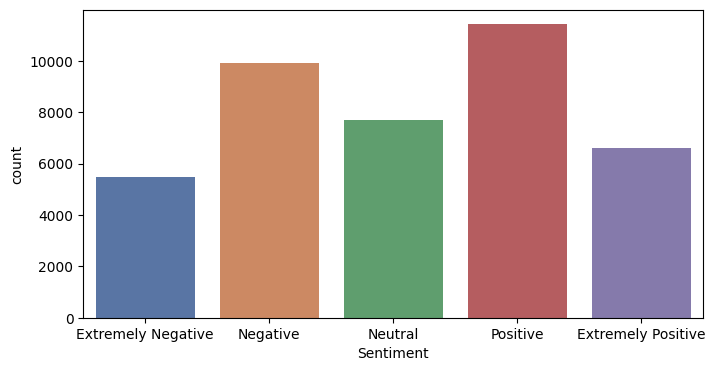

In [7]:
custom_order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
plt.figure(figsize=(8, 4))
sns.countplot(data=TWEETS_DATA, x='Sentiment', order=custom_order, palette='deep')

In [8]:
print(TWEETS_DATA["TweetAt"].value_counts())

TweetAt
20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: count, dtype: int64


We Can see that the data was taken in march and april,  when covid was at its initial peak, 
let's see if the month can tell us something.  
Maybe one month was more negative than the other

month
3    25499
4    15658
Name: count, dtype: int64


/tmp/ipykernel_112991/3598013752.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  TWEETS_DATA["month"] = pd.to_datetime(TWEETS_DATA["TweetAt"]).dt.month


Text(0.5, 1.0, 'Sentiment Distribution by Month')

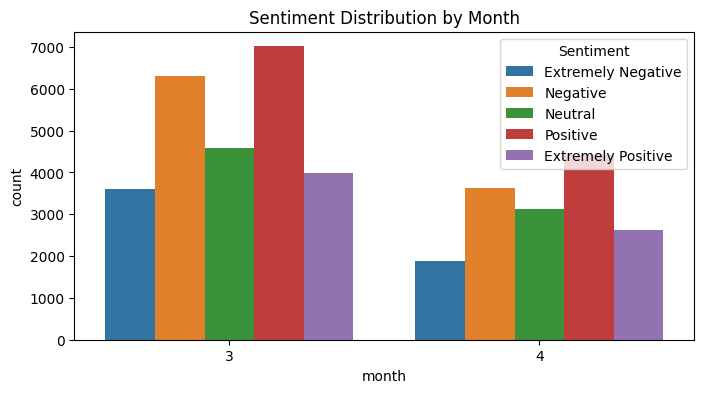

In [9]:
TWEETS_DATA["month"] = pd.to_datetime(TWEETS_DATA["TweetAt"]).dt.month
print(TWEETS_DATA["month"].value_counts())
## plot sentiment by month
plt.figure(figsize=(8,4))
sns.countplot(data=TWEETS_DATA, x='month', hue='Sentiment', hue_order=custom_order)
plt.title('Sentiment Distribution by Month')

It looks like it distributes the same, counting that march had twice has much tweets

In [10]:
print(TWEETS_DATA["Location"].value_counts())

Location
London                           540
United States                    528
London, England                  520
New York, NY                     395
Washington, DC                   373
                                ... 
London / Warwickshire              1
Round Earth                        1
Uganda Kampala                     1
Views don't reflect employers      1
San Mateo, California, USA         1
Name: count, Length: 12220, dtype: int64


It seems that are too many different locations to try to put them together, we will look into it later $$$**##

**Now let's plot the tweets data, let's see what's poping as obvious**

<Axes: xlabel='text_len', ylabel='Count'>

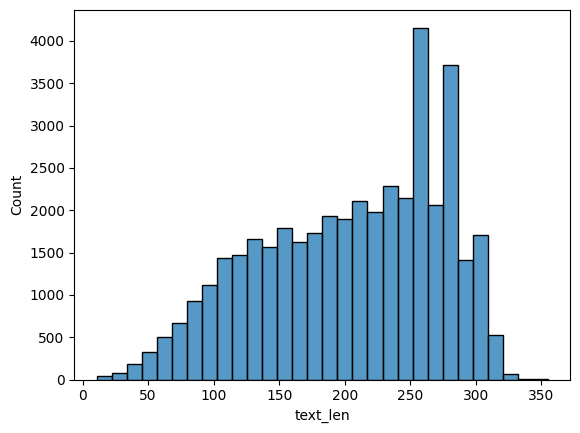

In [11]:
TWEETS_DATA['text_len'] = TWEETS_DATA['OriginalTweet'].str.len()
sns.histplot(TWEETS_DATA['text_len'], bins=30)

We know the tweeter (former X) had a 280 charecters limit, over it are paid users.  
let's see if it can gain us some knowledge

Ratio of positive to negative tweets in paid users: 1.302897278314311
The ratio of positive to negative tweets in free users: 1.1321485532011848


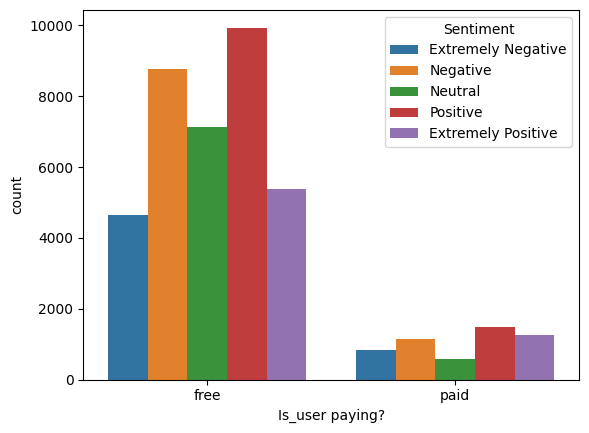

In [12]:
TWEETS_DATA["paid_user"] = TWEETS_DATA["OriginalTweet"].apply(lambda x: "paid" if len(x) > 280 else "free")
sns.countplot(data=TWEETS_DATA, x='paid_user', hue='Sentiment', hue_order=custom_order)
plt.xlabel("Is_user paying?")
paid_users = TWEETS_DATA[TWEETS_DATA['paid_user'] == 'paid']
free_users = TWEETS_DATA[TWEETS_DATA['paid_user'] == 'free']

positive = paid_users[paid_users['Sentiment'].isin(['Positive','Extremley Positive'])]['OriginalTweet'].tolist()
negative = paid_users[paid_users['Sentiment'].isin(['Negative','Extremley Negative'])]['OriginalTweet'].tolist()
print(f"Ratio of positive to negative tweets in paid users: {len(positive) / len(negative)}")

positive = free_users[free_users['Sentiment'].isin(['Positive','Extremley Positive'])]['OriginalTweet'].tolist()
negative = free_users[free_users['Sentiment'].isin(['Negative','Extremley Negative'])]['OriginalTweet'].tolist()
print(f"The ratio of positive to negative tweets in free users: {len(positive) / len(negative)}")


The ratios of negative vs positive are relatively the same for paid and free users, so status isn't a good indicator of sentiment.

## Wordclouds
Wordclouds are a great way to visualize the most common words in the tweets.

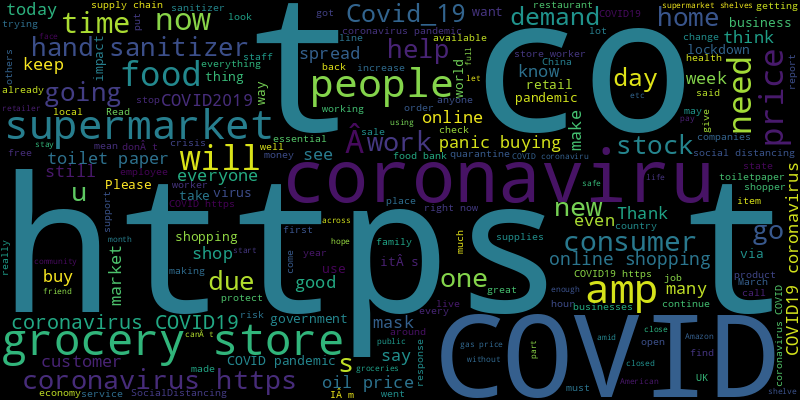

In [13]:
text = " ".join(TWEETS_DATA['OriginalTweet'])
WordCloud(width=800, height=400).generate(text).to_image()

https, amp, t, u, Â, itÂ, donÂ, IÂ  Are HTML tokens that we need to take out of the dataset! 

In [14]:
#INSTEAD OF THIS i SUGGEST DOING THIS (because currently some symbols like \r\r\n\r\r\n are still present):


def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\bamp\b', '', text)                 # Remove "amp"
    text = re.sub(r'\r|\n', ' ', text)                  # Replace \r and \n with space
    text = re.sub(r'\s+', ' ', text).strip()            # Collapse multiple spaces
    return text

#apply:
TWEETS_DATA["tweets"] = TWEETS_DATA["OriginalTweet"].apply(clean_tweet)
TEST_DATA["tweets"] = TEST_DATA["OriginalTweet"].apply(clean_tweet)

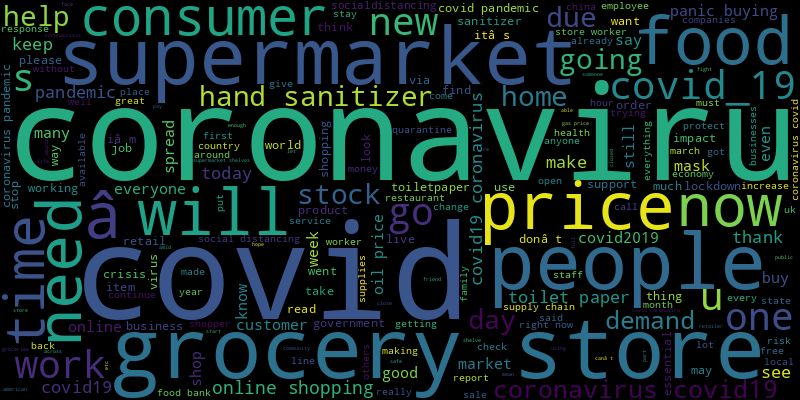

In [15]:
text = " ".join(TWEETS_DATA['tweets'])
WordCloud(width=800, height=400).generate(text).to_image()

In order to take care of weird signs like: 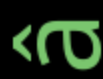  
We tried different encodings (latin and ISO-8859-1)  
We going to take it out manually

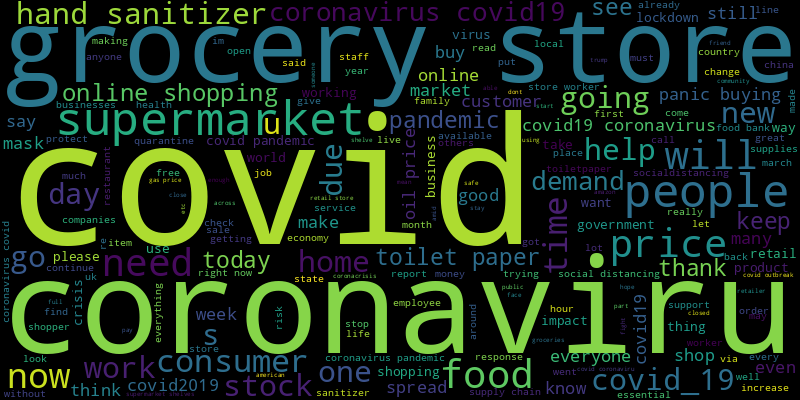

In [92]:
TWEETS_DATA["tweets"] = TWEETS_DATA["tweets"].apply(
    lambda x: x.encode('ascii', errors='ignore').decode()
)

TEST_DATA["tweets"] = TEST_DATA["tweets"].apply(
    lambda x: x.encode('ascii', errors='ignore').decode()
)
text = " ".join(TWEETS_DATA['tweets'])
WordCloud(width=800, height=400).generate(text).to_image()

Now we will explore more wordclouds - per sentiment

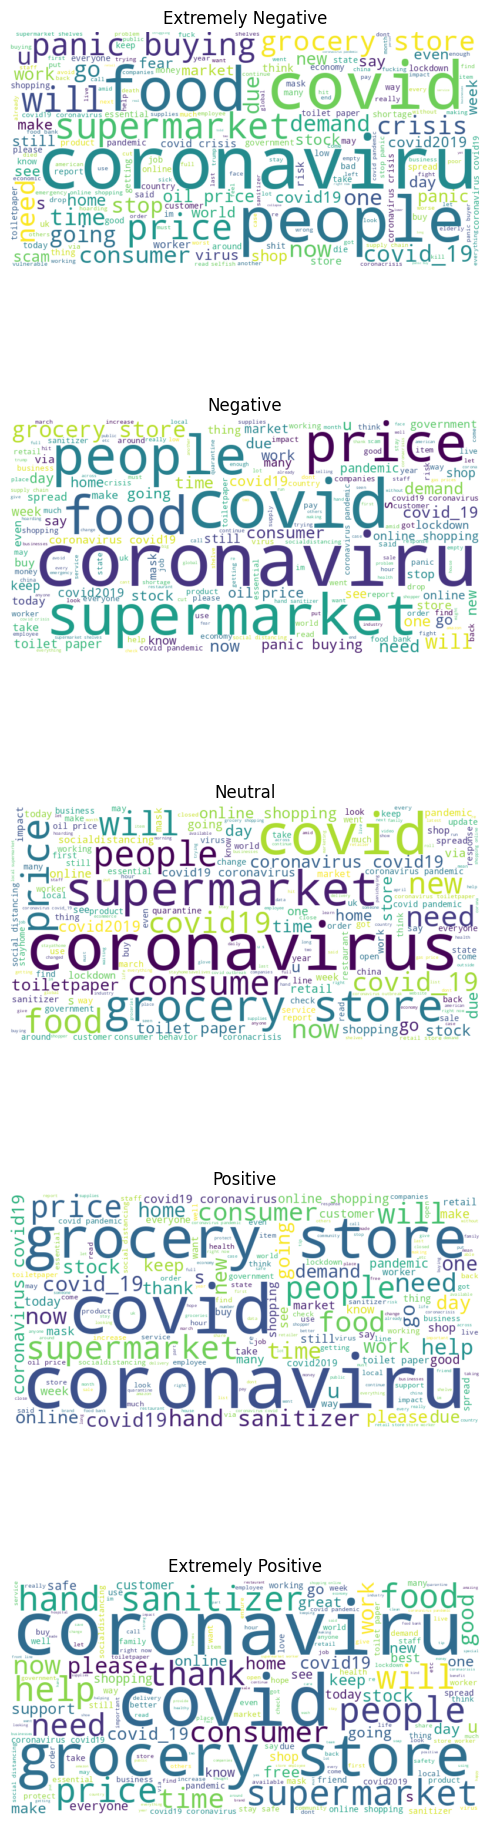

In [93]:
sentiments = custom_order
num_clouds = len(sentiments)

fig, axes = plt.subplots(5, 1, figsize=(5, 20))


# If only one sentiment, axes isn't a list — make it one
if num_clouds == 1:
    axes = [axes]

# Loop through each sentiment and create a word cloud
for ax, sentiment in zip(axes, sentiments):
    subset = TWEETS_DATA[TWEETS_DATA['Sentiment'] == sentiment]
    text = " ".join(subset['tweets'])
    
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(sentiment)
    ax.axis('off')

plt.tight_layout()
plt.show()


Looks like all wordclouds contain similar words, perhaps dipper analysis should be done while extracting covid related key words, to explore better sentiment related words (becuase obsviously positive and negative tweets discussed covid)

**As we all know X (former tweeter) has # and @ in the tweets, let's try to gain some insight from it**

/tmp/ipykernel_89995/3875072588.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_hashtags, x='hashtags', order=top_hashtags, palette='viridis', ax=axes[0])
/tmp/ipykernel_89995/3875072588.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_ats, x='ats', order=top_ats, palette='coolwarm', ax=axes[1])


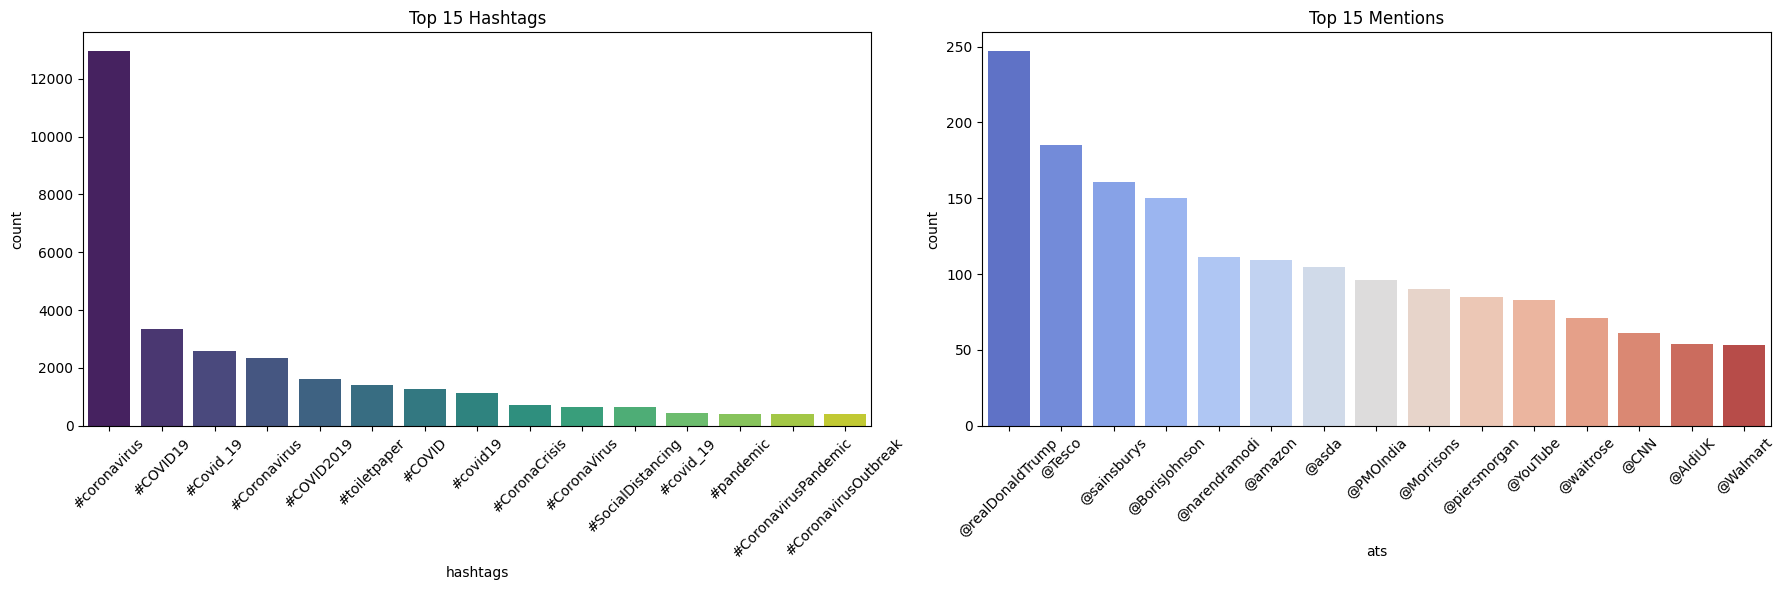

In [94]:

# Extract @ and #
TWEETS_DATA['hashtags'] = TWEETS_DATA['OriginalTweet'].str.findall(r'#\w+')
TWEETS_DATA['ats'] = TWEETS_DATA['OriginalTweet'].str.findall(r'@\w+')

# Explode and clean
hashtags_df = TWEETS_DATA.explode('hashtags')
ats_df = TWEETS_DATA.explode('ats')

hashtags_df = hashtags_df[hashtags_df['hashtags'].notna()]
ats_df = ats_df[ats_df['ats'].notna()]

# Top N
top_n = 15
top_hashtags = hashtags_df['hashtags'].value_counts().nlargest(top_n).index
top_ats = ats_df['ats'].value_counts().nlargest(top_n).index

# Filtered
filtered_hashtags = hashtags_df[hashtags_df['hashtags'].isin(top_hashtags)]
filtered_ats = ats_df[ats_df['ats'].isin(top_ats)]

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

sns.countplot(data=filtered_hashtags, x='hashtags', order=top_hashtags, palette='viridis', ax=axes[0])
axes[0].set_title(f"Top {top_n} Hashtags")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=filtered_ats, x='ats', order=top_ats, palette='coolwarm', ax=axes[1])
axes[1].set_title(f"Top {top_n} Mentions")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


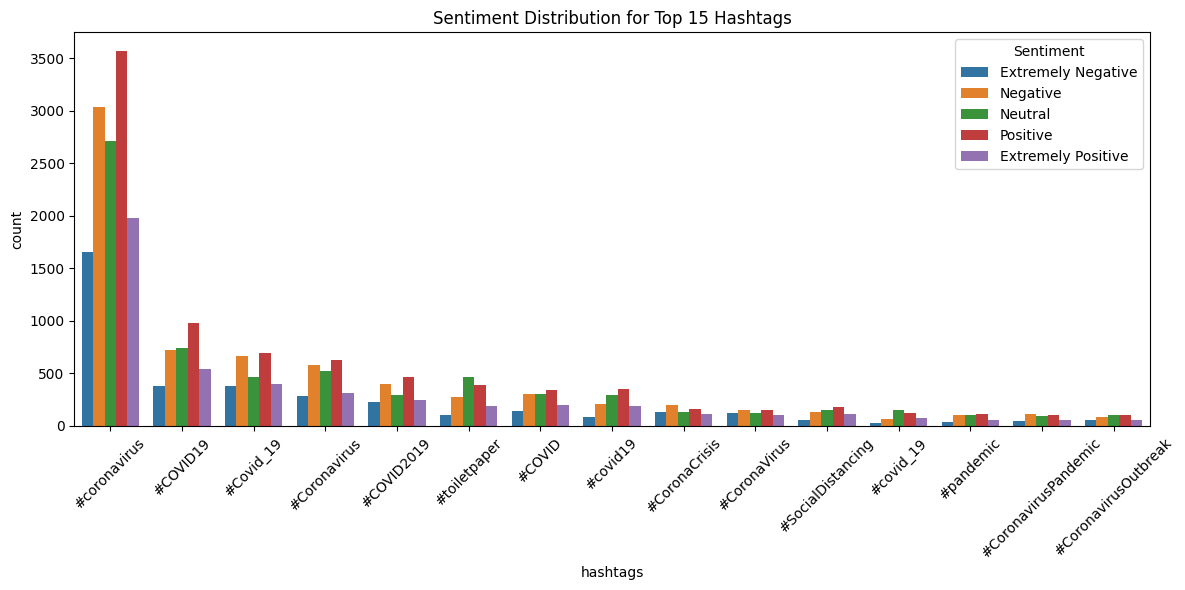

In [95]:
# Filter again to include Sentiment
sentiment_hashtags_df = hashtags_df[hashtags_df['hashtags'].isin(top_hashtags)]

plt.figure(figsize=(12, 6))
sns.countplot(data=sentiment_hashtags_df, x='hashtags', hue='Sentiment', order=top_hashtags, hue_order=custom_order)
plt.title('Sentiment Distribution for Top 15 Hashtags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can see that hashtags are pretty balanced across sentiments, and also that many are variations on same words, like covid, covid19, coronavirus, corona, etc. So hashtags for now don't seem useful.

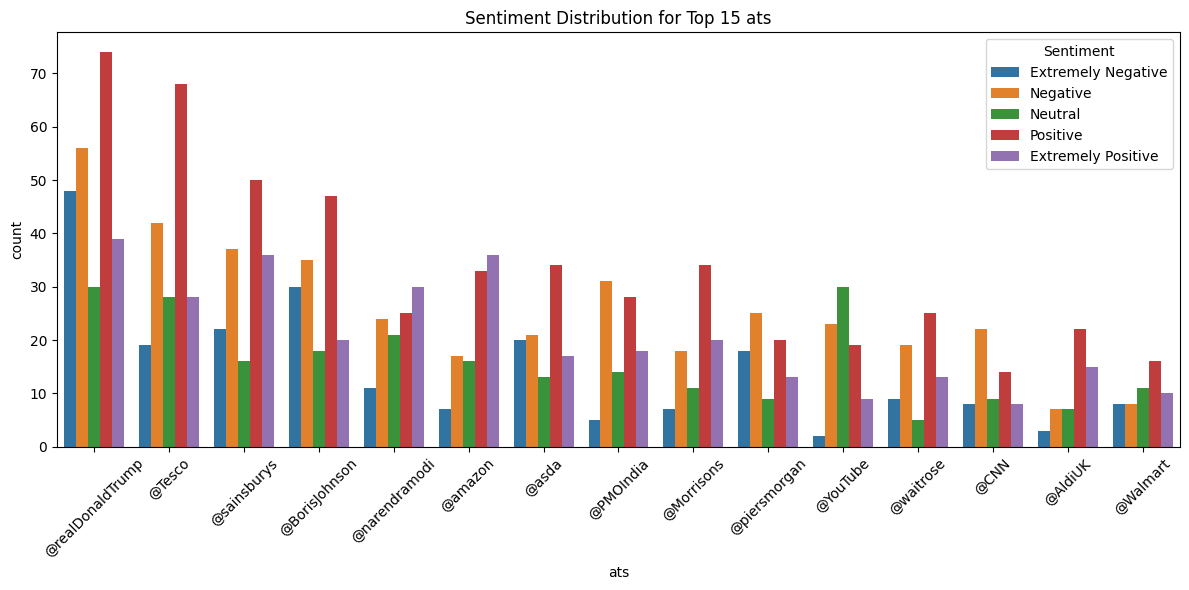

In [96]:
# Filter again to include Sentiment
sentiment_ats_df = ats_df[ats_df['ats'].isin(top_ats)]

plt.figure(figsize=(12, 6))
sns.countplot(data=sentiment_ats_df, x='ats', hue='Sentiment', order=top_ats, hue_order=custom_order)
plt.title('Sentiment Distribution for Top 15 ats')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


@ are more varied, but also are spread across all sentiments

# Preprocessing
After the exploring and some preprocessing we already made (removing special characters, html...), we shall prepare our data to the models of choice

In [97]:
#make labels numerical using a dict:
label_map = {
    "Extremely Negative": 0,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3,
    "Extremely Positive": 4
}
# Convert labels to numerical values
TWEETS_DATA['Sentiment'] = TWEETS_DATA['Sentiment'].map(label_map)
TEST_DATA['Sentiment'] = TEST_DATA['Sentiment'].map(label_map)

In [98]:
TWEETS_DATA
#I can see that there are still some symbols like: \r\r\n\r\r\n - we 

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text_len,paid_user,tweets,hashtags,ats
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,2,3,111,free,@menyrbie @phil_gahan @chrisitv and and,[],"[@MeNyrbie, @Phil_Gahan, @Chrisitv]"
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,3,3,237,free,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order,[],[]
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",3,3,131,free,"coronavirus australia: woolworths to give elderly, disabled dedicated shopping hours amid covid-19 outbreak",[],[]
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",3,3,306,paid,"my food stock is not the only one which is empty... please, don't panic, there will be enough food for everyone if you do not take more than you need. stay calm, stay safe. #covid19france #covid_19 #covid19 #coronavirus #confinement #confinementotal #confinementgeneral","[#COVID19france, #COVID_19, #COVID19, #coronavirus, #confinement, #Confinementotal, #ConfinementGeneral]",[]
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",0,3,310,paid,"me, ready to go at supermarket during the #covid19 outbreak. not because i'm paranoid, but because my food stock is litteraly empty. the #coronavirus is a serious thing, but please, don't panic. it causes shortage... #coronavirusfrance #restezchezvous #stayathome #confinement","[#COVID19, #coronavirus, #CoronavirusFrance, #restezchezvous, #StayAtHome, #confinement]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket shelves in #NZ lockdown #COVID-19 https://t.co/cz89uA0HNp,2,4,102,free,airline pilots offering to stock supermarket shelves in #nz lockdown #covid-19,"[#NZ, #COVID]",[]
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVID-19 related delays. Yet prompt in rejecting policy before consumer TAT is over. Way to go ?,0,4,138,free,response to complaint not provided citing covid-19 related delays. yet prompt in rejecting policy before consumer tat is over. way to go ?,[],[]
41154,44953,89905,NaN,14-04-2020,"You know itÂs getting tough when @KameronWilds is rationing toilet paper #coronavirus #toiletpaper @kroger martinsville, help us out!!",3,4,136,free,"you know its getting tough when @kameronwilds is rationing toilet paper #coronavirus #toiletpaper @kroger martinsville, help us out!!","[#coronavirus, #toiletpaper]","[@KameronWilds, @kroger]"
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer is starting to turn me on?\r\r\n\r\r\n#coronavirus #COVID19 #coronavirus,2,4,111,free,is it wrong that the smell of hand sanitizer is starting to turn me on? #coronavirus #covid19 #coronavirus,"[#coronavirus, #COVID19, #coronavirus]",[]


In [99]:
#prepare data for models: leave only text and labels
train_df = TWEETS_DATA[['tweets', 'Sentiment']]
test_df = TEST_DATA[['tweets', 'Sentiment']]

In [ ]:
# Split into train (70%) and temp (30%)
train_df, eval_df = train_test_split(train_df, test_size=0.3, random_state=42, stratify=train_df['Sentiment'])

#Save 
train_df.to_csv(CSV_PATH / 'train_data.csv', index=False)
test_df.to_csv(CSV_PATH / 'test_data.csv', index=False)
eval_df.to_csv(CSV_PATH / 'eval_data.csv', index=False)

# Models


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim

from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import optuna
import wandb
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel, AutoModelForSequenceClassification, AutoConfig, RobertaForSequenceClassification, BertForSequenceClassification, RobertaTokenizer, BertTokenizer

from dotenv import load_dotenv
import os


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
#login to weights and biases
load_dotenv()
wandb.login(key=os.getenv("WANDB_API_KEY"))

In [ ]:
#second model - bertweet - based on RoBERTa, but trained on 850M english tweets (some related to COVID-19)
####we can also choose this one instead - trained on tweets regarding our domain - covid-19: https://huggingface.co/digitalepidemiologylab/covid-twitter-bert-v2

tweet_model_name = "vinai/bertweet-base"

#checking backbone
tweet_config = AutoConfig.from_pretrained(tweet_model_name)
print(tweet_config.model_type) #printed roberta
tweet_base_attr = 'roberta'

tweet_tokenizer = RobertaTokenizer.from_pretrained(tweet_model_name)
tweet_model = model = RobertaForSequenceClassification.from_pretrained(tweet_model_name, num_labels=5)


covid_model_name = 'digitalepidemiologylab/covid-twitter-bert'

covid_config = AutoConfig.from_pretrained(covid_model_name)
print(covid_config.model_type)  # printed bert
covid_base_attr = 'bert'

covid_tokenizer = AutoTokenizer.from_pretrained(covid_model_name)
covid_model = BertForSequenceClassification.from_pretrained(covid_model_name, num_labels=5)


roberta


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tweet_model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [38]:
covid_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

We can see that bertweet's architecture is similar to RoBERTa's architecture, with 12 layers, and 'covid-tweeter-bert' is based on BERT which has 24 layers, thus a bigger model, and since it was finetuned on our problem, we will expect better performance from it.

## Now we will create a class for our dataset

In [ ]:
#I'm still not sure if we need seperate classes for roberta and bert
class CovidTweetDataset(Dataset): # Dataset Class
    def __init__(self, dataframe, tokenizer):
        # Extract the 'text_combined' and 'label' columns from the DataFrame
        self.texts = dataframe['tweets'].tolist()
        self.labels = dataframe['Sentiment'].tolist()
        self.tokenizer = tokenizer # Tokenizer for text processing

    def __len__(self): #Returns the total number of samples in the dataset.
        # This method is required for PyTorch's DataLoader to work !!
        return len(self.texts)

    def __getitem__(self, idx): #Retrieves a single data sample and its label at the specified index.
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text using the provided tokenizer
        encoding = self.tokenizer(
            text,
            padding='max_length', # Add padding to reach the maximum length
            truncation=True, # Trim if the text is longer than max_length
            max_length=512, # Maximum sequence length allowed
            return_tensors='pt')

        return { # Return a dictionary containing tokenized inputs, attention masks, and the label
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)}
    
    

## training loop

In [ ]:
#as always, define early stopping
def early_stop_check(patience, best_val_accuracy, best_val_accuracy_epoch, current_val_accuracy, current_val_accuracy_epoch):
    early_stop_flag = False
    if current_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_val_accuracy
        best_val_accuracy_epoch = current_val_accuracy_epoch
    else:
        if current_val_accuracy_epoch - best_val_accuracy_epoch > patience:
            early_stop_flag = True
    return best_val_accuracy, best_val_accuracy_epoch, early_stop_flag

In [42]:
def train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs, patience, trial):
    best_val_accuracy = 0.0
    best_val_accuracy_epoch = 0
    early_stop_flag = False
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train() # Enable training mode
        train_loss = 0.0
        total_train_samples = 0
        correct_train_predictions = 0

        for batch in train_loader: #Iterates over the train_loader, which is a DataLoader object containing batches of training data.
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad() # Reset gradients
            outputs = model(input_ids, attention_mask=attention_mask) # Forward pass
            logits = outputs.logits # save the logits (the raw output of the model)
            loss = criterion(logits, labels) # Calculate loss

            loss.backward() # Backward pass
            optimizer.step() # Update weights using the optimizer 

            # Accumulate training loss and predictions
            train_loss += loss.item() * input_ids.size(0)
            total_train_samples += input_ids.size(0)
            correct_train_predictions += (logits.argmax(dim=1) == labels).sum().item()

        train_loss /= total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples

        ###  Validation loop  ###
        model.eval() # Enable evaluation mode
        val_loss = 0.0
        total_val_samples = 0
        correct_val_predictions = 0

        all_val_labels = []
        all_val_preds = []

        with torch.no_grad(): # Disable gradient computation
            for batch in val_loader: # iterate on the val_loader's batches 
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)

                val_loss += loss.item() * input_ids.size(0)
                total_val_samples += input_ids.size(0)
                correct_val_predictions += (logits.argmax(dim=1) == labels).sum().item()

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(logits.argmax(dim=1).cpu().numpy())

        # calculate metrics 
        val_loss /= total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples
        val_precision = precision_score(all_val_labels, all_val_preds, average='binary')
        val_recall = recall_score(all_val_labels, all_val_preds, average='binary')
        val_f1 = f1_score(all_val_labels, all_val_preds, average='binary')

        # Check for early stopping
        best_val_accuracy, best_val_accuracy_epoch, early_stop_flag = early_stop_check(patience, best_val_accuracy, best_val_accuracy_epoch, val_accuracy, epoch)

        # Save the best model under the best_model_state parameter
        if val_accuracy == best_val_accuracy:
            best_model_state = model.state_dict()

        # Log metrics to Weights & Biases - THIS IS WHERE WE TRACK THE RESULTS AND THE PROCESS
        wandb.log({ #log == logging of the training process (e.g. results) - will be done each epoch
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Train Accuracy": train_accuracy,
            "Validation Loss": val_loss,
            "Validation Accuracy": val_accuracy,
            "Validation Precision": val_precision,
            "Validation Recall": val_recall,
            "Validation F1": val_f1})

        if early_stop_flag:  # Checks whether the early stopping condition has been met, as indicated by the early_stop_flag
            break # Exits the training loop immediately if the early stopping condition is satisfied

    #NOT SURE IF WE SHOULD CHANGE IT'S LOCATION
    if best_model_state is not None: # Save the best model as a .pt file
        torch.save(best_model_state, f"best_model_trial_{trial.number}.pt")

    return best_val_accuracy

## Optuna objective function

In [ ]:
# Objective Function for Optuna
def objective(trial, tokenizer, model_name, model, base_attr, project_name, training_type, train_df, eval_df):
    # Hyperparameter suggestions - WE SHOULD ADD MORE HYPERPARAMETERS HERE
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-4)
    patience = trial.suggest_int("patience", 7, 10)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    num_layers = trial.suggest_int("num_layers", 1, 3, 5)
    
    # Create the dataset and dataloaders
    train_dataset = CovidTweetDataset(train_df, tokenizer) # Create the CovidTweetDataset object
    eval_dataset = CovidTweetDataset(eval_df, tokenizer) # Create the CovidTweetDataset object

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # insert into a DataLoader
    val_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False) # insert into a DataLoader

    model = model.to(device) # we initialize every model outside the objective function

    #finetuning
    for param in model.base_attr.parameters():    # Freeze layers
        param.requires_grad = False
    for param in model.base_attr.encoder.layer[-num_layers:].parameters():     # unfreeze the last "num_layers" of the encoder
        param.requires_grad = True
    for param in model.classifier.parameters():    #unfreeze the classifier
        param.requires_grad = True

    # Define optimizer and loss function
    criterion = nn.CrossEntropyLoss() #multiclass classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) #maybe also try adamW

    # Initialize Weights & Biases - the values in the config are the properties of each trial.
    wandb.init(project=project_name,
               config={ 
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "patience": patience,
        "batch_size": batch_size,
        "num_layers": num_layers,
        "architecture": model_name,
        "training_type": training_type,
        "dataset": "corona_virus_NLP"}, 
        name=f"{project_name}_{training_type}_trial_{trial.number}") # The name that will be saved in the W&B platform

    # Train the model and get the best validation accuracy
    best_val_accuracy = train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs=20, patience=patience, trial=trial)

    wandb.finish() # Finish the Weights & Biases run
    
    return best_val_accuracy # Return best validation acc as the objective to maximize

In [ ]:
# Optuna Study
  #CHANGE so that it will be defined by the main function!!
study = optuna.create_study(study_name=study_name, irection="maximize")  #we should chnage it to be from config
study.optimize(objective, n_trials=10)

#and also add all params of objective function to the study:
#(trial, tokenizer, model_name, model, base_attr, project_name, training_type, train_df, eval_df):